In [1]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import pickle
from torch.optim.lr_scheduler import StepLR
import time
from PIL import Image
from torchsummary import summary
import time
import cv2

import seaborn as sns

pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", 100000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
# To mount drive:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
# Checking GPU:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
def get_data_from_drive(copy = True, extract = True):
  start = time.time()
  if copy:
    print("Copying Train Source from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/nasa_tropical_storm_competition_train_source.tar" -r "/content/nasa_tropical_storm_competition_train_source.tar"
    print("Copying Test Source from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/nasa_tropical_storm_competition_test_source.tar" -r "/content/nasa_tropical_storm_competition_test_source.tar"
    print("Copying Train Metadata from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/train.csv" -r "/content/train.csv"
    print("Copying Test Metadata from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/test.csv" -r "/content/test.csv"

  if extract:
    print("Extracting Training Images")
    !tar -xvf "/content/nasa_tropical_storm_competition_train_source.tar" -C "/content/"
    print("Extracting Test Images")
    !tar -xvf "/content/nasa_tropical_storm_competition_test_source.tar" -C "/content/"
  
  print("Data Ready! Time Taken: {:.4f}s".format(time.time() - start))

  
def get_image_paths(data, image_dir, folder_name):
    data["image_path"] = image_dir + "/" + folder_name + "_" + data["image_id"] + "/" + "image.jpg"
    data = data[data.columns[[0, 2, 5, 1, 3, 4]]]
    return data
    

In [6]:
def write_model_losses(filename, losses):
  print("Saving model losses to drive.")
  with open("/content/drive/MyDrive/DS5500 Data/{}.pkl".format(filename), "wb") as f:
    pickle.dump(losses, f)
    

def plot_predictions(wind_speed, metadata):
    sample_img = metadata[metadata.wind_speed == wind_speed][["image_path","predictions"]].iloc[:5]
    for i,img in enumerate(sample_img.image_path):
        # im = Image.open(img) 
        # im.show(title = sample_img["predictions"].iloc[i])
        image = mpimg.imread(img)
        plt.title("Actual: "+ str(wind_speed) +"   Predicted: " + str(round(sample_img["predictions"].iloc[i],2)))
        plt.imshow(image, cmap = "gray")
        plt.show()
    return 

def loadModel(model_path, model = None):
  state_dict = torch.load(model_path)
  model.load_state_dict(state_dict)
  return model

In [7]:
# extract and save losses from model training print statements

def extract_and_save_losses_from_print_statements(loss_text, model_name, save=False):
  loss_text_list = loss_text.split("\n")
  loss_text_list = [text for text in loss_text_list if text.startswith("Epoch:")]
  loss_text_list = [text.split(",") for text in loss_text_list]
  # loss_text_list
  losses = {"train_loss": [], "valid_loss": []}
  for i in loss_text_list:
    losses["train_loss"].append(float(i[1].split(":")[1].strip()))
    losses["valid_loss"].append(float(i[2].split(":")[1].strip()))

  # model_name = "baseline_CNN_ADAM_0.0001"
  losses_filename = "{}_losses".format(model_name)
  if save:
    write_model_losses(losses_filename, losses)
  
  return losses

In [8]:
def get_data_in_intervals(metadata, interval):
  
  data_dict = dict()
  counter = 0
  for name, group in metadata.groupby(by="storm_id"):
    group = group.sort_values(by="relative_time").reset_index()
    # print(name, group.index)
    # removing storms with just one rgb image
    if group.shape[0] > 2*interval+1:
      for i in range(0, group.shape[0]):
        i2 = i-interval
        i3 = i2-interval
        if i3 >= 0 and i2 > 0:
          # print(i, i2, i3)
          lis = [group.image_path[i3], group.image_path[i2], group.image_path[i]]
          # storm_id = metadata.storm_id[i3]
          wind_speed = group.wind_speed[i]

          if counter not in data_dict.keys():
            data_dict[counter] = {"storm_id": name, "image_list": lis, "wind_speed": wind_speed, "ocean":  group.ocean[i]}
          counter += 1

  df = pd.DataFrame.from_dict(data_dict, orient="index").reset_index().drop(columns="index")

  return df

In [9]:
def create_bins(df):
  # specify condition
  conditions = [(df["wind_speed"] >= 15) & (df["wind_speed"] <= 25),
                (df["wind_speed"] >= 26) & (df["wind_speed"] <= 35),
                (df["wind_speed"] >= 36) & (df["wind_speed"] <= 55),
                (df["wind_speed"] >= 56) & (df["wind_speed"] <= 85),
                # (df["wind_speed"] >= 76) & (df["wind_speed"] <= 90),
                (df["wind_speed"] > 85)]

  values = ["15 to 25", "26 to 35", "36 to 55", "56 to 85", ">=86"]

  # conditions = [(df["wind_speed"] >= 15) & (df["wind_speed"] <= 25),
  #               (df["wind_speed"] >= 26) & (df["wind_speed"] <= 35),
  #               (df["wind_speed"] >= 36) & (df["wind_speed"] <= 45),
  #               (df["wind_speed"] >= 46) & (df["wind_speed"] <= 55),
  #               (df["wind_speed"] >= 56) & (df["wind_speed"] <= 75),
  #               (df["wind_speed"] > 75)]

  # values = ["15 to 25", "26 to 35", "36 to 45", "46 to 55", "56 to 75", ">75"]

  df["Wind Labels"] = np.select(conditions, values)
  # print("Bins created!")

  return df

In [10]:
def display_sample_images(dataloader, batch_size, sample_size, num_rows):

  sample_size = min(sample_size, batch_size)
  images, labels = next(iter(dataloader))
  images = images.numpy()

  fig = plt.figure(figsize = (30, 10))
  for i in np.arange(sample_size):
      ax = fig.add_subplot(num_rows, sample_size/num_rows, i+1, xticks = [], yticks = [])
      ax.imshow(np.squeeze(np.transpose(images[i], (1, 2 ,0))))
      ax.set_title("Wind Speed: {}".format(str(labels[i].item())))
      # ax.set_title("Wind Label: {}".format(str(class_dict[labels[i].item()])))
      # ax.set_title(str(get_labels_for_one_hot(labels[i], class_dict)))
  
  return

In [11]:
class HurricaneImageDataset(Dataset):

    def __init__(self, metadata, transform = None, add_color=False):
        self.metadata = metadata # new: with list of image paths, wind speed
        if transform is None:
          transform = transforms.Compose([
                      # transforms.RandomResizedCrop(224),
                      transforms.Resize((366, 366)),
                      # transforms.RandomRotation(90),
                      # transforms.Grayscale(num_output_channels=1),
                      # transforms.RandomHorizontalFlip(),
                      # transforms.RandomVerticalFlip(),
                      # transforms.CenterCrop(90),
                      transforms.ToTensor(),
                      # transforms.Normalize([0.5], [0.5])
                      # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
              ])
        self.transforms = transform
        self.add_color = add_color

    def __len__(self):
        return len(self.metadata)

    def convert_to_threeband(self, img_list):
      def add_rgb_to_images(img):
        # create 1 pixel red image
        red = np.zeros((1, 1, 3), np.uint8)
        red[:] = (0,0,255)
        # resize lut to 256 values
        # # create 1 pixel blue image
        blue = np.zeros((1, 1, 3), np.uint8)
        blue[:] = (255,0,0)
        # resize lut to 256 values
        # # create 1 pixel green image
        green = np.zeros((1, 1, 3), np.uint8)
        green[:] = (0,255,0)
        # append the three images
        lut = np.concatenate((red, green, blue), axis=0)
        lut = cv2.resize(lut, (1,256), interpolation=cv2.INTER_CUBIC)
        # apply lut
        result = cv2.LUT(img, lut)
        return result
      
      # Reading the three images
      img1 = cv2.imread(img_list[0], cv2.IMREAD_GRAYSCALE) # t - 2*interval
      img2 = cv2.imread(img_list[1], cv2.IMREAD_GRAYSCALE) # t - interval
      img3 = cv2.imread(img_list[2], cv2.IMREAD_GRAYSCALE) # t

      # Merge the three images to convert to three equal channels
      img = cv2.merge((img3, img2, img1))
      # img = img/255
      # print(img)

      # Add color if True
      if self.add_color:
        img = add_rgb_to_images(img)
        
      # return np.asarray(img)
      # return img
      return Image.fromarray(img)

    def __getitem__(self, index):
      if torch.is_tensor(index):
          index = index.tolist()

      # rgb_image = []
      image_paths = self.metadata["image_list"][index]
      hurricane_image = self.convert_to_threeband(image_paths)
      # for ip in image_paths:
      #   img = Image.open(image_path)
      #   rgb_image.append(img)
      # hurricane_image = io.imread(image_path)
      
      label = self.metadata["wind_speed"][index]

      if self.transforms:
        hurricane_image = self.transforms(hurricane_image)

      return hurricane_image, label

In [12]:
from sklearn.preprocessing import LabelEncoder
def label_encode(df, col_name):
  le = LabelEncoder()
  le.fit(df[col_name])
  df['wind_label_encoded'] = le.transform(df[col_name])
  classes = {i:cls for i,cls in enumerate(le.classes_)}
  return df, classes

In [13]:
def train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename):

  valid_loss_min = np.Inf
  losses = {"train_loss": [], "valid_loss": []}
  start = time.time()

  for e in range(1, epochs + 1):
    train_loss, valid_loss = 0.0, 0.0

    # Training the model:
    model.train()
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        optimizer.zero_grad()
        output = model(data)
        # print("Size: {}".format(output.size()))
        loss = criterion(output, target)
        loss.backward()
        # print(loss)
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # Validating the model:
    model.eval()
    for data, target in validloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    
    if scheduler is not None:
        scheduler.step(valid_loss)

    train_loss = train_loss / len(trainloader.dataset)
    losses["train_loss"].append(train_loss)
    valid_loss = valid_loss / len(validloader.dataset)
    losses["valid_loss"].append(valid_loss)
    write_model_losses(losses_filename, losses)

    print("Epoch: {}/{}, Train Loss: {:.5f}, Validation Loss: {:.5f}".format(e, epochs, train_loss, valid_loss))


    if valid_loss <= valid_loss_min:
        print('Decrease in Validation Loss: ({:.6f} to {:.6f}). Saving Model...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name))
        valid_loss_min = valid_loss
    
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Training: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
  write_model_losses(losses_filename, losses)
    
  return losses 

In [14]:
def model_evaluation(dataloader, model, criterion, device):
    # specify loss function
  predictions = torch.FloatTensor().cpu()
    # criterion = nn.MSELoss()
  total_MSE_loss, total_RMSE_loss = 0.0, 0.0
    # specify optimizer
    # optimizer = optim.Adam(model.parameters(), lr = 0.015)
  model.eval()
    # for data, target in validloader:
    #     data, target = data.to(device), target.to(device)
    #     target = target.float().unsqueeze(1)
    #     output = model(data)
    #     loss = criterion(output, target)
    #     valid_loss += loss.item() * data.size(0)
  with torch.no_grad():
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        output = model(data)
        predictions = torch.cat((predictions, output.cpu()), 0)
        # print(predictions)
        #RMSE
        MSE_loss = criterion(output, target)
        RMSE_loss = torch.sqrt(MSE_loss)
        total_MSE_loss += MSE_loss.item()*data.size(0)
        total_RMSE_loss += RMSE_loss.item()*data.size(0)
    total_MSE_loss = total_MSE_loss / len(dataloader.dataset)
    total_RMSE_loss = total_RMSE_loss / len(dataloader.dataset)

  # pass entire testloader, get outputs and append to test_metadata
  preds_df = pd.DataFrame(predictions, columns = ['predictions']).astype("float")
  return preds_df, total_MSE_loss, total_RMSE_loss

In [15]:
# Testing Model on Data:

def test(model, testloader, criterion, num_classes, class_dict):

  test_loss, accuracy = 0.0, 0.0
  class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))
  model.eval()

  for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)
      test_loss += loss.item()*images.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

      for i in range(len(labels)):
          label = labels.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(testloader.sampler)
  print("Test Loss: {}".format(test_loss))

  for i in range(num_classes):
      if class_total[i] > 0:
          print("Test Accuracy of {}: {:.3f}%. Frac: {}/{}".format(str(class_dict[i]), 100*(class_correct[i]/class_total[i]), 
                                                        np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print("Test Accuracy of {}: N/A (no training examples)".format(classes[i]))
  print("\n Test Accuracy (Overall): {:.3f}. Frac {}/{}".format((100 * np.sum(class_correct)/np.sum(class_total)), 
                                                            np.sum(class_correct), np.sum(class_total)))
  
  return

In [16]:
get_data_from_drive(copy=True, extract=True)

Streaming output truncated to the last 5000 lines.
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_kzg_017/image.jpg
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_kzg_017/stac.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_kzg_017/features.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/image.jpg
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/stac.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/features.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_hld_147/
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_hld_147/image.jpg
nasa_

In [17]:
# resampling - upsample
from sklearn.utils import resample
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
# define the dataset location
def sampling(train_metadata, type_ = "over"):
  class_dict = dict()
  for i in train_metadata.wind_label_encoded.unique():
    class_dict[i] = train_metadata.loc[train_metadata.wind_label_encoded == i]
  
  if type_ == 'over':
    type_key,type_value = max([(key,value.shape[0])for key,value in class_dict.items()], key = lambda item:item[1])
  else:
    type_key,type_value = min([(key,value.shape[0])for key,value in class_dict.items()], key = lambda item:item[1])
  
  new_df = pd.DataFrame()
  for key,value in class_dict.items():
    if key != type_key:
      X, y = value[["storm_id","image_list","ocean","wind_speed"]], value['wind_label_encoded']
      X_sampled, y_sampled = resample(X, y, replace=True, n_samples=type_value, random_state=123)
      df_sampled = pd.concat([X_sampled, y_sampled], axis = 1).reset_index().drop("index", axis=1)
      new_df = pd.concat([new_df, df_sampled], ignore_index = True)
    else:
      new_df = pd.concat([new_df, value], ignore_index = True)
  
  new_df = new_df.sample(frac=1).reset_index(drop=True)

  return new_df

def uniform_sampling(train_metadata, type_ = "over"):
  class_dict = dict()
  for i in train_metadata.wind_label_encoded.unique():
    class_dict[i] = train_metadata.loc[train_metadata.wind_label_encoded == i]
  
  avg_ = 0
  type_value = 0

  for key,value in class_dict.items():
    avg_ += value.shape[0]
  
  type_value = avg_ // len(class_dict)

  new_df = pd.DataFrame()
  for key,value in class_dict.items():
    X, y = value[["storm_id","image_list","ocean","wind_speed"]], value['wind_label_encoded']
    X_sampled, y_sampled = resample(X, y, replace=True, n_samples=type_value, random_state=123)
    df_sampled = pd.concat([X_sampled, y_sampled], axis = 1).reset_index().drop("index", axis=1)
    new_df = pd.concat([new_df, df_sampled], ignore_index = True)
  
  new_df = new_df.sample(frac=1).reset_index(drop=True)

  return new_df


In [18]:
rs = np.random.RandomState(111) # creating a random state for reproducibility of random generators
data_dir = "/content/"
train_metadata_og = pd.read_csv("{}/train.csv".format(data_dir))
test_metadata_og = pd.read_csv("{}/test.csv".format(data_dir))

train_folder_name = "nasa_tropical_storm_competition_train_source"
test_folder_name = "nasa_tropical_storm_competition_test_source"
train_image_dir = "{}/{}".format(data_dir, train_folder_name)
test_image_dir = "{}/{}".format(data_dir, test_folder_name)

# msk = rs.rand(len(train_metadata)) < 0.8
# train_metadata2 = train_metadata[msk].reset_index().drop("index", axis=1)
# valid_metadata = train_metadata[~msk].reset_index().drop("index", axis=1)


train_metadata = get_image_paths(train_metadata_og, train_image_dir, train_folder_name)
test_metadata = get_image_paths(test_metadata_og, test_image_dir, test_folder_name)
# valid_metadata = get_image_paths(valid_metadata, train_image_dir, train_folder_name)

interval = 9
train_metadata = get_data_in_intervals(train_metadata, interval)
# valid_metadata = get_data_in_intervals(valid_metadata, interval)
test_metadata = get_data_in_intervals(test_metadata, interval)

train_metadata = create_bins(train_metadata)
test_metadata = create_bins(test_metadata)
# valid_metadata = create_bins(valid_metadata)

train_metadata, train_label_dict = label_encode(train_metadata, 'Wind Labels')
test_metadata, test_label_dict = label_encode(test_metadata,'Wind Labels')

print("original class distribution: ")
print(train_metadata.wind_label_encoded.value_counts())
print(train_label_dict)

# removing storms with min number of groups <= 2
# x = pd.DataFrame(train_metadata.groupby(by = 'wind_label_encoded').storm_id.value_counts() > 2)
# x = x.loc[x.storm_id == True].drop("storm_id", axis = 1).reset_index()["storm_id"]
# train_metadata = train_metadata.loc[train_metadata.storm_id.isin(x)]

from sklearn.model_selection import train_test_split

X,y = train_metadata[["storm_id","image_list","ocean",'wind_label_encoded']], train_metadata["wind_speed"]
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=101, stratify=train_metadata["storm_id"], shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=101,shuffle=True)
X_train, X_valid = pd.DataFrame(X_train), pd.DataFrame(X_valid)
train_metadata = pd.concat([X_train, y_train], axis = 1).reset_index().drop("index", axis=1)
valid_metadata = pd.concat([X_valid, y_valid], axis = 1).reset_index().drop("index", axis=1)
train_metadata = uniform_sampling(train_metadata)
# valid_metadata, valid_label_dict = label_encode(valid_metadata,'Wind Labels')
print("new class distribution: ")
print(train_metadata.wind_label_encoded.value_counts())
print(valid_metadata.wind_label_encoded.value_counts())

original class distribution: 
2    18822
1    12650
3    12285
0    9692 
4    8188 
Name: wind_label_encoded, dtype: int64
{0: '15 to 25', 1: '26 to 35', 2: '36 to 55', 3: '56 to 85', 4: '>=86'}
new class distribution: 
4    9861
3    9861
2    9861
1    9861
0    9861
Name: wind_label_encoded, dtype: int64
2    3725
1    2587
3    2509
0    1938
4    1569
Name: wind_label_encoded, dtype: int64


In [19]:
print(train_metadata.shape, valid_metadata.shape, test_metadata.shape)

(49305, 5) (12328, 5) (37913, 6)


In [20]:
train_metadata.head()

,storm_id,image_list,ocean,wind_speed,wind_label_encoded
0,erx,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_erx_028/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_erx_037/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_erx_046/image.jpg]",2,105,4
1,xgr,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_xgr_049/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_xgr_058/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_xgr_067/image.jpg]",1,90,4
2,zny,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_zny_338/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_zny_347/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_zny_356/image.jpg]",1,75,3
3,buv,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_buv_198/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_buv_207/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_buv_216/image.jpg]",1,25,0
4,ilk,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_ilk_070/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_ilk_079/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_ilk_088/image.jpg]",1,90,4


In [21]:
transform = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize((366, 366)),
        # transforms.RandomRotation(90),
        # transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.CenterCrop(90),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5])
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [22]:
trainset = HurricaneImageDataset(train_metadata, transform)
testset = HurricaneImageDataset(test_metadata)
validset = HurricaneImageDataset(valid_metadata)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)
validloader = DataLoader(validset, batch_size=128, shuffle=True)

In [23]:
images,labels = next(iter(testloader))

In [24]:
images.shape

torch.Size([128, 3, 366, 366])

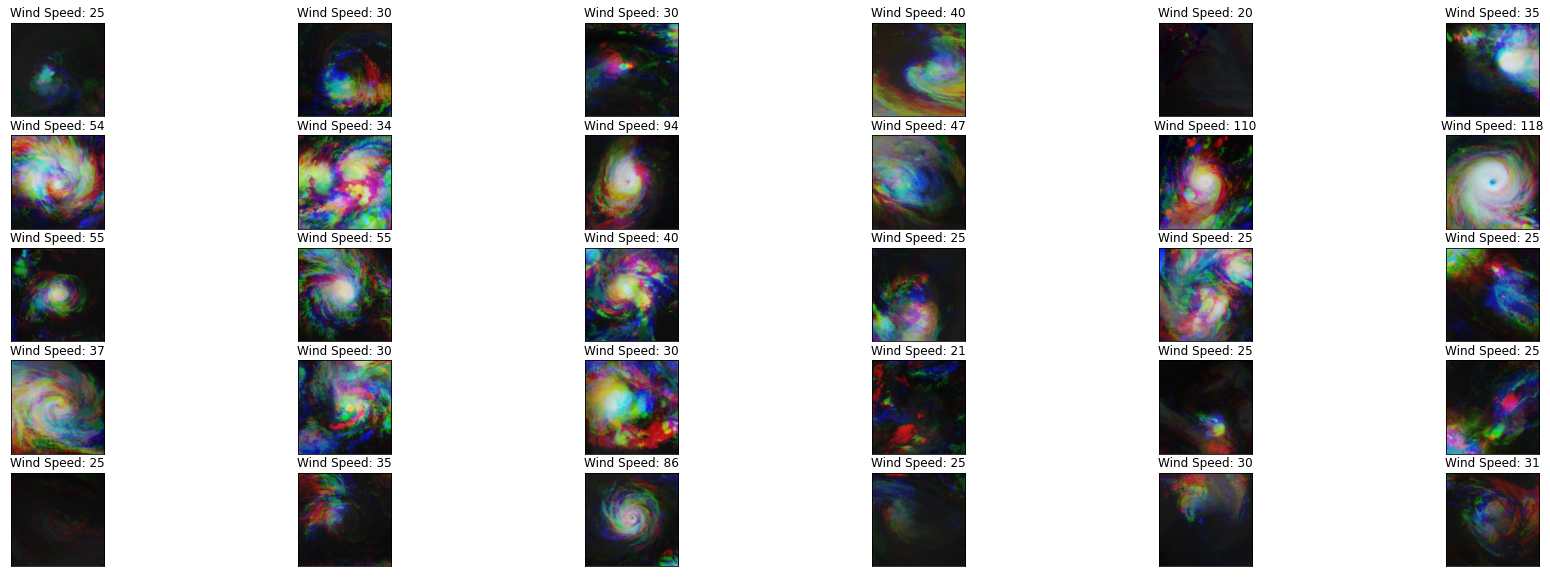

In [25]:
sample_size = 30
batch_size = 32
num_rows = 5

display_sample_images(trainloader, batch_size, sample_size, num_rows)

In [26]:
train_label_dict

{0: '15 to 25', 1: '26 to 35', 2: '36 to 55', 3: '56 to 85', 4: '>=86'}

In [ ]:
# Densenet161
densenet161 = models.densenet161(pretrained = True)
# densenet161
# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False
# # Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                          #  nn.Linear(512, 128),
                          #  nn.ReLU(),
                          #  nn.Dropout(0.20),
                           nn.Linear(512, len(train_label_dict)))
# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
model = densenet161 # resize images to 366x366, batch_size = 64
model_name = "densenet161_ADAM_e35_b256_00003_classifier"
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
model.to(device)
# print(model)

# Loss function
criterion = nn.CrossEntropyLoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
lr = 0.0003
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=3, min_lr=lr*(factor**6), eps=1e-8, verbose=True)
# scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 17
model_name = "densenet161_ADAM_e35_b256_00003_classifier_v2"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 CrossEntropyLoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)

Saving model losses to drive.
Epoch: 1/35, Train Loss: 0.86735, Validation Loss: 0.85258
Decrease in Validation Loss: (inf to 0.852584). Saving Model...
Saving model losses to drive.
Epoch: 2/35, Train Loss: 0.83753, Validation Loss: 0.83565
Decrease in Validation Loss: (0.852584 to 0.835653). Saving Model...
Saving model losses to drive.
Epoch: 3/35, Train Loss: 0.81425, Validation Loss: 0.85378
Saving model losses to drive.
Epoch: 4/35, Train Loss: 0.79144, Validation Loss: 0.79790
Decrease in Validation Loss: (0.835653 to 0.797895). Saving Model...
Saving model losses to drive.
Epoch: 5/35, Train Loss: 0.77609, Validation Loss: 0.79699
Decrease in Validation Loss: (0.797895 to 0.796991). Saving Model...
Saving model losses to drive.
Epoch: 6/35, Train Loss: 0.75544, Validation Loss: 0.78790
Decrease in Validation Loss: (0.796991 to 0.787902). Saving Model...
Saving model losses to drive.
Epoch: 7/35, Train Loss: 0.73462, Validation Loss: 0.77008
Decrease in Validation Loss: (0.787902 to 0.770079). Saving Model...
Saving model losses to drive.
Epoch: 8/35, Train Loss: 0.71647, Validation Loss: 0.75977
Decrease in Validation Loss: (0.770079 to 0.759767). Saving Model...
Saving model losses to drive.
Epoch: 9/35, Train Loss: 0.70638, Validation Loss: 0.74822
Decrease in Validation Loss: (0.759767 to 0.748216). Saving Model...
Saving model losses to drive.
Epoch: 10/35, Train Loss: 0.68125, Validation Loss: 0.74409
Decrease in Validation Loss: (0.748216 to 0.744086). Saving Model...
Saving model losses to drive.
Epoch: 11/35, Train Loss: 0.66465, Validation Loss: 0.72815
Decrease in Validation Loss: (0.744086 to 0.728153). Saving Model...
Saving model losses to drive.
Epoch: 12/35, Train Loss: 0.64632, Validation Loss: 0.72196
Decrease in Validation Loss: (0.728153 to 0.721963). Saving Model...
Saving model losses to drive.
Epoch: 13/35, Train Loss: 0.62617, Validation Loss: 0.72132
Decrease in Validation Loss: (0.721963 to 0.721315). Saving Model...
Saving model losses to drive.
Epoch: 14/35, Train Loss: 0.60497, Validation Loss: 0.72126
Decrease in Validation Loss: (0.721315 to 0.721258). Saving Model...
Saving model losses to drive.
Epoch: 15/35, Train Loss: 0.58634, Validation Loss: 0.70640
Decrease in Validation Loss: (0.721258 to 0.706398). Saving Model...
Saving model losses to drive.
Epoch: 16/35, Train Loss: 0.56513, Validation Loss: 0.68874
Decrease in Validation Loss: (0.706398 to 0.688738). Saving Model...
Saving model losses to drive.
Epoch: 17/35, Train Loss: 0.54370, Validation Loss: 0.67459
Decrease in Validation Loss: (0.688738 to 0.674588). Saving Model...
Saving model losses to drive.
Epoch: 18/35, Train Loss: 0.52261, Validation Loss: 0.66323
Decrease in Validation Loss: (0.674588 to 0.663225). Saving Model...
Saving model losses to drive.
Epoch: 19/35, Train Loss: 0.51791, Validation Loss: 0.67607

In [ ]:
criterion = nn.CrossEntropyLoss()
model_name = "densenet161_ADAM_e35_b256_0001_classifier"
model = densenet161
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
model.to(device)
test(model,testloader,criterion,5, test_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()
model_name = "densenet161_ADAM_e35_b256_00003_classifier"
model = densenet161
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
model.to(device)
test(model,testloader,criterion,5, test_label_dict)

Test Loss: 1.0448853312827098
Test Accuracy of 15 to 25: 67.172%. Frac: 5498.0/8185.0
Test Accuracy of 26 to 35: 53.035%. Frac: 4552.0/8583.0
Test Accuracy of 36 to 45: 26.943%. Frac: 1716.0/6369.0
Test Accuracy of 46 to 75: 66.827%. Frac: 6652.0/9954.0
Test Accuracy of >=76: 76.628%. Frac: 3695.0/4822.0

 Test Accuracy (Overall): 58.326. Frac 22113.0/37913.0


In [ ]:
# Densenet161
densenet161 = models.densenet161(pretrained = True)
# densenet161
# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False
# # Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 128),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(128, 5))
# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
model = densenet161 # resize images to 366x366, batch_size = 64
# model_name = "densenet161_ADAM_e35_b256_00003_classifier"
# model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
# model = loadModel(model_path, densenet161)
model.to(device)
# print(model)

# Loss function
criterion = nn.CrossEntropyLoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
lr = 0.0003
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=2, min_lr=lr*(factor**6), eps=1e-8, verbose=True)
# scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 35
model_name = "densenet161_ADAM_e35_b256_00003_classifier_v2"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 CrossEntropyLoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)

Saving model losses to drive.
Epoch: 1/35, Train Loss: 1.04781, Validation Loss: 0.89891
Decrease in Validation Loss: (inf to 0.898909). Saving Model...
Saving model losses to drive.
Epoch: 2/35, Train Loss: 0.89112, Validation Loss: 0.86135
Decrease in Validation Loss: (0.898909 to 0.861347). Saving Model...
Saving model losses to drive.
Epoch: 3/35, Train Loss: 0.85448, Validation Loss: 0.83226
Decrease in Validation Loss: (0.861347 to 0.832262). Saving Model...
Saving model losses to drive.
Epoch: 4/35, Train Loss: 0.82410, Validation Loss: 0.81236
Decrease in Validation Loss: (0.832262 to 0.812358). Saving Model...
Saving model losses to drive.
Epoch: 5/35, Train Loss: 0.80143, Validation Loss: 0.81666
Saving model losses to drive.
Epoch: 6/35, Train Loss: 0.78058, Validation Loss: 0.78848
Decrease in Validation Los

In [ ]:
criterion = nn.CrossEntropyLoss()
model_name = "densenet161_ADAM_e35_b256_00003_classifier_v2"
model = densenet161
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
model.to(device)
test(model,testloader,criterion,5, test_label_dict)

Test Loss: 1.4548108440354446
Test Accuracy of 15 to 25: 65.229%. Frac: 5339.0/8185.0
Test Accuracy of 26 to 35: 48.142%. Frac: 4132.0/8583.0
Test Accuracy of 36 to 45: 30.743%. Frac: 1958.0/6369.0
Test Accuracy of 46 to 75: 65.732%. Frac: 6543.0/9954.0
Test Accuracy of >=76: 76.462%. Frac: 3687.0/4822.0

 Test Accuracy (Overall): 57.128. Frac 21659.0/37913.0


In [ ]:
#densenet 161 resplit data
densenet161 = models.densenet161(pretrained = True)
# densenet161
# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False
# # Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                          #  nn.Linear(512, 128),
                          #  nn.ReLU(),
                          #  nn.Dropout(0.20),
                           nn.Linear(512, len(train_label_dict)))
# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=6, bias=True)
)

In [ ]:
model = densenet161 # resize images to 366x366, batch_size = 256
# model_name = "densenet161_ADAM_e35_b256_00003_classifier"
# model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
# model = loadModel(model_path, densenet161)
model.to(device)
# print(model)

# Loss function
criterion = nn.CrossEntropyLoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
lr = 0.0003
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=2, min_lr=lr*(factor**6), eps=1e-8, verbose=True)
# scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 35
model_name = "densenet161_ADAM_e35_b256_00003_classifier_v2_resplit_data"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 CrossEntropyLoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)

Saving model losses to drive.
Epoch: 1/35, Train Loss: 1.19463, Validation Loss: 1.06870
Decrease in Validation Loss: (inf to 1.068701). Saving Model...
Saving model losses to drive.
Epoch: 2/35, Train Loss: 1.04682, Validation Loss: 1.02125
Decrease in Validation Loss: (1.068701 to 1.021252). Saving Model...
Saving model losses to drive.
Epoch: 3/35, Train Loss: 1.00797, Validation Loss: 0.99501
Decrease in Validation Loss: (1.021252 to 0.995008). Saving Model...
Saving model losses to drive.
Epoch: 4/35, Train Loss: 0.98070, Validation Loss: 0.99421
Decrease in Validation Loss: (0.995008 to 0.994206). Saving Model...
Saving model losses to drive.
Epoch: 5/35, Train Loss: 0.95699, Validation Loss: 0.96415
Decrease in Validation Loss: (0.994206 to 0.964148). Saving Model...
Saving model losses to drive.
Epoch: 6/35, Tra

KeyboardInterrupt: ignored

In [ ]:
criterion = nn.CrossEntropyLoss()
model_name = "densenet161_ADAM_e35_b256_00003_classifier_v2_resplit_data"
model = densenet161
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
model.to(device)
test(model,testloader,criterion,len(train_label_dict), test_label_dict)

Test Loss: 1.1960481571936743
Test Accuracy of 15 to 25: 66.878%. Frac: 5474.0/8185.0
Test Accuracy of 26 to 35: 49.621%. Frac: 4259.0/8583.0
Test Accuracy of 36 to 45: 34.103%. Frac: 2172.0/6369.0
Test Accuracy of 46 to 55: 26.059%. Frac: 1181.0/4532.0
Test Accuracy of 56 to 75: 47.455%. Frac: 2573.0/5422.0
Test Accuracy of >75: 77.478%. Frac: 3736.0/4822.0

 Test Accuracy (Overall): 51.157. Frac 19395.0/37913.0


In [25]:
# Densenet161
densenet161 = models.densenet161(pretrained = True)
# densenet161
# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False
# # Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                          #  nn.Linear(512, 128),
                          #  nn.ReLU(),
                          #  nn.Dropout(0.20),
                           nn.Linear(512, len(train_label_dict)))
# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)

In [26]:
model = densenet161 # resize images to 366x366, batch_size = 256
model_name = "densenet161_ADAM_e35_b32_00003_classifier_upsampled_data_v2"
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
model.to(device)
# print(model)

# Loss function
criterion = nn.CrossEntropyLoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
lr = 0.0003
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=2, min_lr=lr*(factor**6), eps=1e-8, verbose=True)
# scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 30
model_name = "densenet161_ADAM_e35_b32_00003_classifier_upsampled_data_v2"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 CrossEntropyLoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)

Saving model losses to drive.
Epoch: 1/30, Train Loss: 0.78411, Validation Loss: 0.70328
Decrease in Validation Loss: (inf to 0.703278). Saving Model...
Saving model losses to drive.
Epoch: 2/30, Train Loss: 0.76100, Validation Loss: 0.73263
Saving model losses to drive.
Epoch: 3/30, Train Loss: 0.74141, Validation Loss: 0.71224
Saving model losses to drive.
Epoch: 4/30, Train Loss: 0.72329, Validation Loss: 0.65900
Decrease in Validation Loss: (0.703278 to 0.658999). Saving Model...
Saving model losses to drive.
Epoch: 5/30, Train Loss: 0.70137, Validation Loss: 0.64514
Decrease in Validation Loss: (0.658999 to 0.645144). Saving Model...
Saving model losses to drive.
Epoch: 6/30, Train Loss: 0.68979, Validation Loss: 0.62619
Decrease in Validation Loss: (0.645144 to 0.626186). Saving Model...
Saving model losses to dri

In [27]:
criterion = nn.CrossEntropyLoss()
model_name = "densenet161_ADAM_e35_b32_00003_classifier_upsampled_data_v2"
model = densenet161
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
model.to(device)
test(model,testloader,criterion,len(train_label_dict), test_label_dict)

Test Loss: 1.3280901965220104
Test Accuracy of 15 to 25: 68.002%. Frac: 5566.0/8185.0
Test Accuracy of 26 to 35: 44.821%. Frac: 3847.0/8583.0
Test Accuracy of 36 to 45: 29.769%. Frac: 1896.0/6369.0
Test Accuracy of 46 to 75: 66.215%. Frac: 6591.0/9954.0
Test Accuracy of >=76: 73.642%. Frac: 3551.0/4822.0

 Test Accuracy (Overall): 56.580. Frac 21451.0/37913.0


In [27]:
# Densenet161 Classifier


densenet161 = models.densenet161(pretrained = True)
# densenet161

# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False


# # Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 1))
                          #  nn.LogSoftmax(dim = 1))

# classifier = nn.Sequential(nn.Conv2d(3, 16, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Conv2d(16, 32, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Conv2d(32, 64, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Conv2d(64, 128, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Linear(128*22*22, 32),
#                            nn.ReLU(),
#                            nn.Dropout(0.25),
#                            nn.Linear(32, 1))



# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
model = densenet161 # resize images to 366x366, batch_size = 64
model.to(device)
# print(model)
model_name = "densenet161_ADAM_e20_b128_001_da_wo_flip_uniform_sample"
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
model = loadModel(model_path, densenet161)
# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
lr = 0.001
# lr = 9.0000e-05 # retraining lr or lasst 5 epochs
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=3, min_lr=lr*(factor**2), eps=1e-8, verbose=True)
# scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)
print("Scheduler:\n", scheduler)

epochs = 10
model_name = "densenet161_ADAM_e20_b128_001_da_wo_flip_uniform_sample"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 MSELoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Scheduler:

Saving model losses to drive.
Epoch: 1/10, Train Loss: 145.02085, Validation Loss: 121.17837
Decrease in Validation Loss: (inf to 121.178367). Saving Model...
Saving model losses to drive.
Epoch: 2/10, Train Loss: 146.46766, Validation Loss: 121.36055
Saving model losses to drive.
Epoch: 3/10, Train Loss: 143.10493, Validation Loss: 131.38374
Saving model losses to drive.
Epoch: 4/10, Train Loss: 141.34515, Validation Loss: 122.67394
Epoch     5: reducing learning rate of group 0 to 3.0000e-04.
Saving model losses to drive.
Epoch: 5/10, Train Loss: 142.71099, Validation Loss: 126.85992
Saving model losses to drive.
Epoch: 6/10, Train Loss: 139.11516, Validation Loss: 119.30452
Decrease in Validation Loss: (121.178367 to 119.304522). Saving Model...
Saving model losses to drive.
Epoch: 7/10, Train Loss: 136.77069, Valid

In [80]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = densenet161
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(trainloader, best_model, criterion, device)
res_df = pd.concat([train_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

113.55305195487179 10.61789574124406


In [81]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = densenet161
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(validloader, best_model, criterion, device)
res_df = pd.concat([valid_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

117.28427795370548 10.799969312357176


In [30]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = densenet161.cuda()
model_name = "densenet161_ADAM_e20_b128_001_da_wo_flip_uniform_sample"
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
best_model = loadModel(model_path, densenet161)

criterion = nn.MSELoss()
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(testloader, best_model, criterion, device)
res_df = pd.concat([test_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

117.73474019410078 10.80652689084191
